In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

from scipy.interpolate import make_interp_spline

from scipy.spatial import ConvexHull

ModuleNotFoundError: No module named 'ccfj'

In [ ]:
import sys
sys.path.append(r'../')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [ ]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/repartrition_01-03/'               # Harmon server
name_project

'project_repartrition/output_repar_06-01/'

In [ ]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartrition/output_repar_06-01/


In [ ]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [ ]:
name_project_based = info_basic['name_project_based']
dir_project_based = os.path.join(dir_project_workspace, name_project_based)
print('dir_project_based: ', dir_project_based)

dir_project_based:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/


In [ ]:
filename = dir_project_based+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_based = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi_based = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [ ]:
key_subworks_based = info_basic_based['key_subworks'][0::50]
key_subworks_based

['04-02',
 '54-02',
 '50-03',
 '46-04',
 '42-05',
 '38-06',
 '34-07',
 '30-08',
 '26-09',
 '22-10',
 '18-11',
 '14-12',
 '10-13',
 '06-14',
 '56-14',
 '52-15',
 '48-16',
 '44-17',
 '40-18',
 '36-19']

In [ ]:
dir_image = dir_project+info_basic['dir_image']

### Calculate each F-J spectrograms' average Velocity

In [ ]:
def calculate_velocity(key_subwork):
    global f
    global c
    global info_basic
    global info_basic_based
    global info_basic_bi_based  
    global f_sample
    global flag_1
    global flag_2
    global c_mean
    global c_mean_data
    global flag_plot
    global dir_project_based
    global dir_image

    dir_ds_based = dir_project_based + info_basic_based['dir_ds']
    ds = h5py.File(dir_ds_based+'ds_'+key_subwork+'.h5', 'r')

    ds_remove = ds['ds_remove'][0]
    #ds_new_1 = ds_remove[np.logical_and(c>flag_1[0],c < flag_1[1]),:]
    #ds_new_2 = ds_remove[np.logical_and(c>flag_2[0],c < flag_2[1]),:]
    f_sample = []
    c_sample = []
    c_new = c[np.logical_and(c>flag_1[0],c < flag_1[1])]
    for index_f in range(len(f)):
        if f[index_f] < flag_1[2] or f[index_f] > flag_2[3]:
            continue
        if f[index_f] >= flag_1[2] and f[index_f] < flag_1[3]:
            index_c = np.where(ds_remove[np.logical_and(c>flag_1[0],c < flag_1[1]),index_f] == np.max(ds_remove[np.logical_and(c>flag_1[0],c < flag_1[1]),index_f] ))[0][0]
        else:
            index_c = np.where(ds_remove[np.logical_and(c>flag_2[0],c < flag_2[1]),index_f]  == np.max(ds_remove[np.logical_and(c>flag_2[0],c < flag_2[1]),index_f] ))[0][0]
        f_sample.append(f[index_f])
        c_sample.append(c_new[index_c])
    c_mean[key_subwork] = np.mean(c_sample)
    f_smooth = np.linspace(f[index_f].min(), f[index_f].max(), 300)  # np.linspace 等差数列,从x.min()到x.max()生成300个数，便于后续插值
    c_smooth = make_interp_spline(f[index_f], c_new[index_c])(f_smooth)
    print('finish '+key_subwork)
    if flag_plot == 1:
        fig,ax = plt.subplots(1,1,figsize=(8,6))
        title0 = "Linear stack dispersion curve "
        ax = plotlib.plot_fj(ax,ds_remove,title0,f,c,0,c_map='jet')
        index_f = 400
        f_p = f[index_f]
        #index_c = np.where(np.abs(ds_remove[:,f==f_p]) == np.max(np.abs(ds_remove[:,f==f_p])))[0][0]
        #ax.scatter(f_sample,c_sample,c='g',s=20)
        ax.scatter(f_smooth,c_smooth,c='g',s=20)
        plt.savefig(dir_image+ 'Autopick_'+key_subwork+'.png')
        #plt.close()

In [ ]:
f = info_basic_bi_based['f']
c = np.linspace(info_basic_based['c_min'],info_basic_based['c_max'],info_basic_based['c_num'])

NameError: name 'info_basic_bi_based' is not defined

In [ ]:
flag_1 = [0.3,0.9,8,10]
flag_2 = [0.3,0.61,10,16]
nThreads = 45
c_mean = {}
c_mean_data = np.zeros(len(f))
flag_plot = 1
flag_multiple = 0

In [ ]:
if flag_multiple ==1:
    pool = ThreadPoolExecutor(max_workers = nThreads)
    for key_subwork in key_subworks_based:
        pool.submit(calculate_velocity,key_subwork)
    pool.shutdown()
else:
    for key_subwork in key_subworks_based:
        calculate_velocity(key_subwork)

NameError: name 'flag_multiple' is not defined

### Plot

In [35]:
stalistname_all = info_basic_based['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist() 
lat_all =  stainfo['latitude'].tolist() 
lon_all =  stainfo['longitude'].tolist() 

In [36]:
#key_subworks_based = info_basic['key_subworks_based']
c_mean_data = []
lat_this = []
lon_this = []
for key_subwork in key_subworks_based:
    key = 'R'+key_subwork[0:2]+key_subwork[3:]
    if key in stalist_all:
        lat_this.append(lat_all[stalist_all.index(key)])
        lon_this.append(lon_all[stalist_all.index(key)])
    else:
        key1 = 'R' + str(int(key_subwork[0:2])-1).zfill(2)+key_subwork[3:5]
        key2 = 'R' + str(int(key_subwork[0:2])+1).zfill(2)+key_subwork[3:5]
        indx1 = stalist_all.index(key1)
        indx2 = stalist_all.index(key2)
        lat_this.append((lat_all[indx1]+lat_all[indx2])/2)
        lon_this.append((lon_all[indx1]+lon_all[indx2])/2)
    c_mean_data.append(c_mean[key_subwork])

In [37]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

(-116.59694834999999,
 -116.58567665000001,
 33.534672199722195,
 33.542851800013224)

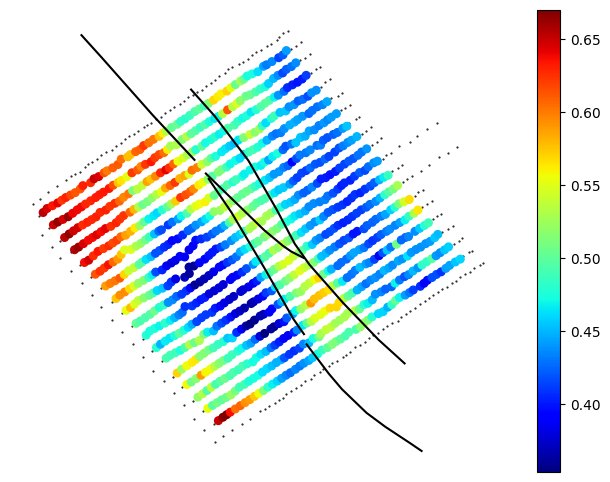

In [38]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
c_min = 0.4
c_max = 0.5
ax.scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k')
im = ax.scatter(lon_this, lat_this,c=c_mean_data,cmap='jet',s=30)
#im = ax.scatter(lon_this, lat_this,c=c_mean_data,cmap='jet',s=30,vmin = c_min,vmax = c_max)
plt.colorbar(im)
    
ax.axis('off')

### Cluster

In [45]:
def hierarchical_clustering(lons, lats, values, n_clusters):
    coordinates_and_values = np.column_stack((lons, lats, values))
    scaler = StandardScaler()
    coordinates_and_values_scaled = scaler.fit_transform(coordinates_and_values)
    
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = hierarchical.fit_predict(coordinates_and_values_scaled)
    
    return clusters

In [46]:
n_clusters = 19
clusters = hierarchical_clustering(lon_this, lat_this, c_mean_data, n_clusters)

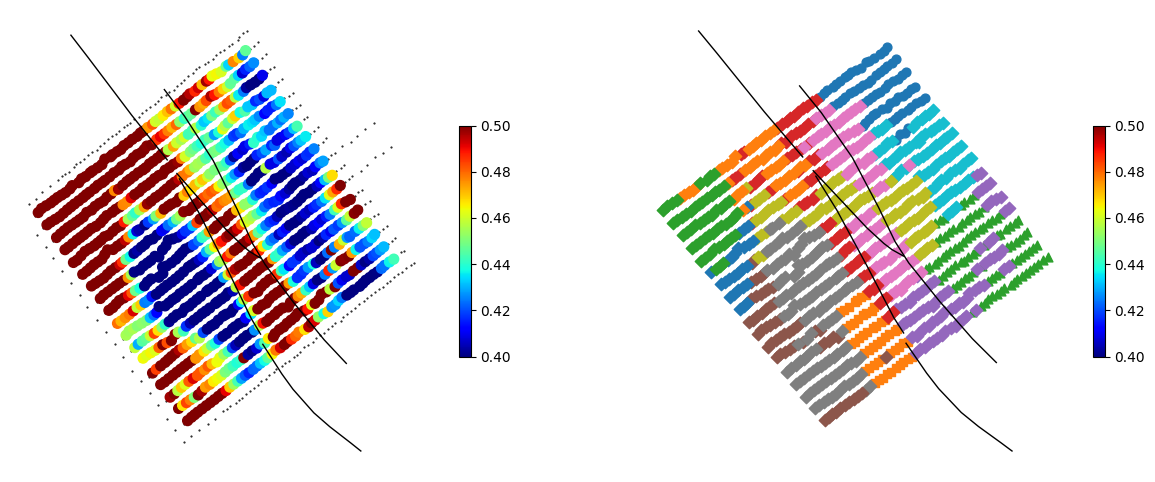

In [47]:
# ax00
fig, ax = plt.subplots(1,2,figsize=(15,6))
ax[0].scatter(lon_all, lat_all,marker='.',color='k',s=1)
for i in range(len(faults)):
    ax[0].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k',lw = 1)
#im = ax[0].scatter(lon_this, lat_this,c=c_mean_data,cmap='jet',s=30)
im = ax[0].scatter(lon_this, lat_this,c=c_mean_data,cmap='jet',s=50,vmin = c_min,vmax = c_max)
plt.colorbar(im,ax = ax[0],shrink=0.5)
ax[0].axis('off')

# ax01
for cluster in range(n_clusters):
    cluster_points = np.column_stack((np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster]))
    ax[1].scatter(cluster_points[:, 0], cluster_points[:, 1], s=40, marker='o' if cluster == 0 else 's' if cluster == 1 else '^' if cluster == 2 else 'D', label=f'Cluster {cluster + 1}')
#plt.legend()
ax[1].axis('off')
# 给第二个子图添加colorbar
plt.colorbar(im, ax=ax[1], shrink=0.5)
for i in range(len(faults)):
    ax[1].plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k',lw = 1)
plt.savefig(dir_image + 'Autopick_Cluster.png')

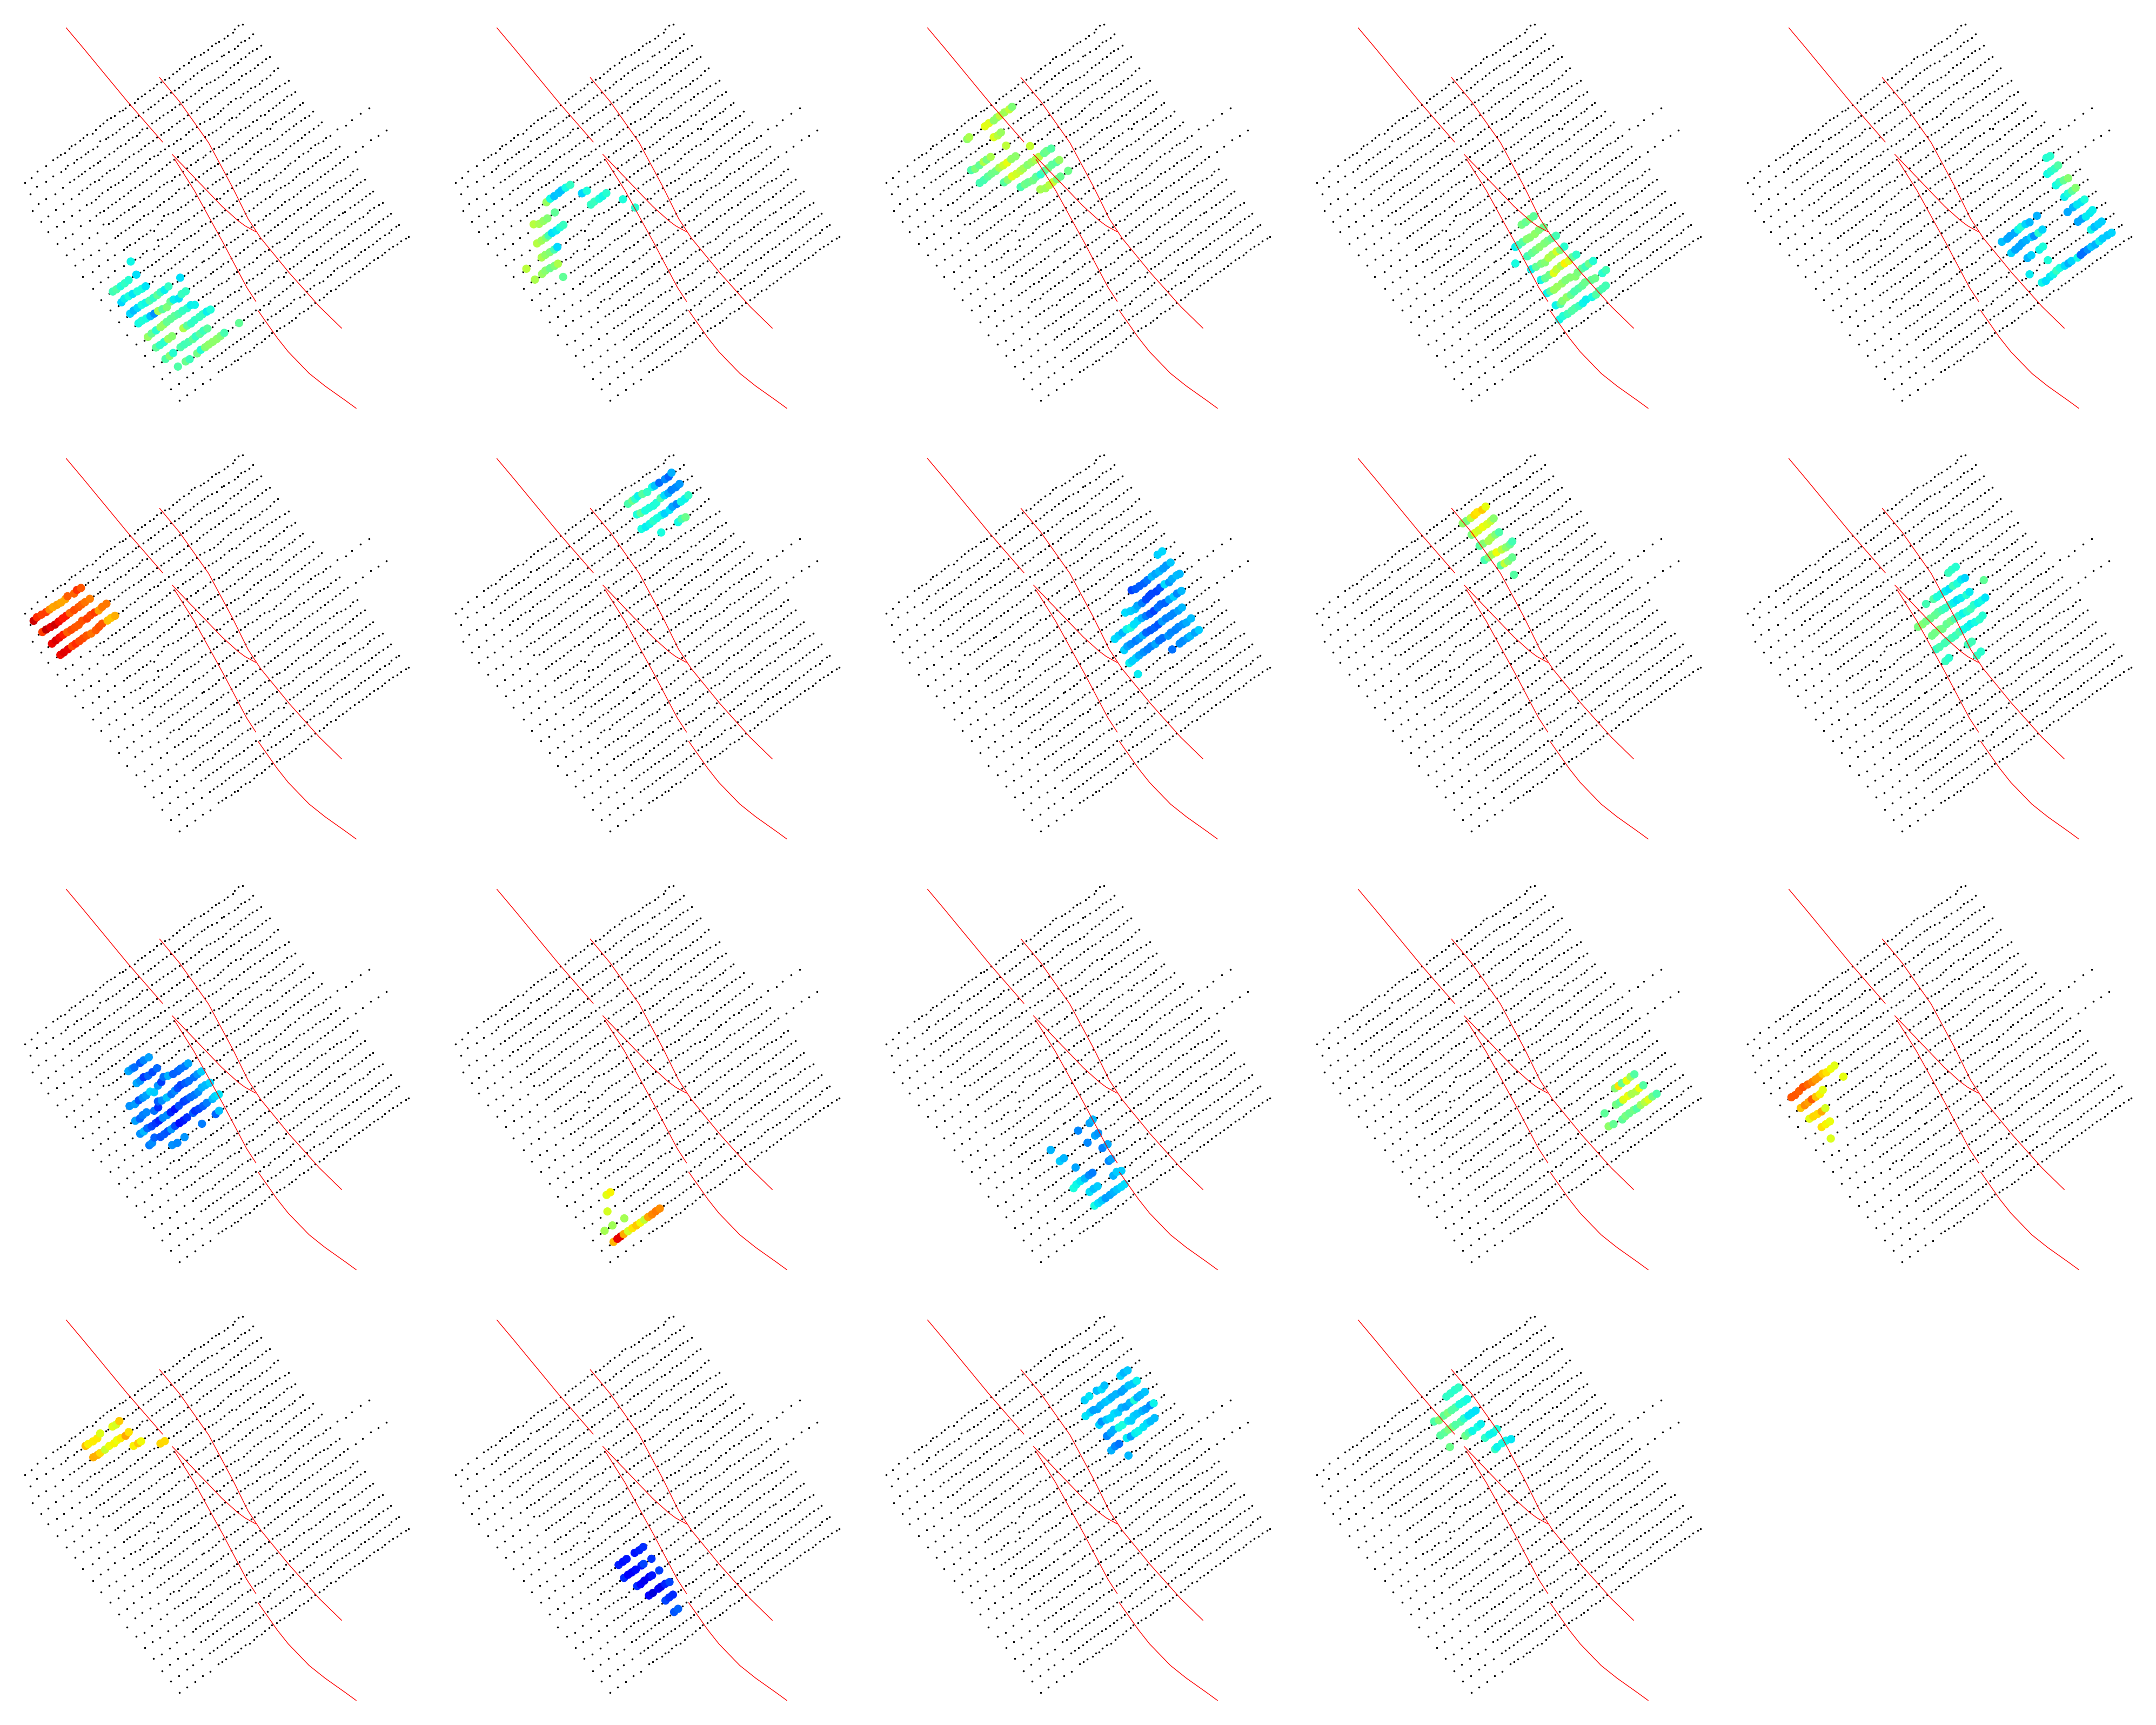

In [21]:
c_min = 0.3
c_max = 0.7
n_cols = int(np.ceil(np.sqrt(n_clusters)))
n_rows = int(np.ceil(n_clusters / n_cols))
fig = plt.figure(figsize=(8*(n_rows+1), 8*n_cols))


for cluster in range(n_clusters):
    col_num = cluster % n_cols
    row_num = int(cluster / n_cols)
    ax = plt.subplot(n_rows+1, n_cols, n_cols+cluster + 1)
    ax.scatter(lon_all, lat_all,marker='.',color='k',s=10)
    for i in range(len(faults)):
        plt.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'r',lw = 1)
    im = ax.scatter(np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster],c=np.array(c_mean_data)[clusters == cluster],cmap='jet',s=100,vmin = c_min,vmax = c_max)
    ax.axis('off')
    #plt.colorbar(im,ax=ax[cluster])
plt.tight_layout()
plt.savefig(dir_image + 'Autopick_Cluster_all.png')

### Convex envelop

In [22]:
hull_points_all = {}
hull_all = {}
for cluster in range(n_clusters):
    cluster_points = np.column_stack((np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster]))
    hull_all[cluster] = ConvexHull(cluster_points)
    hull_points_all[cluster] = cluster_points[hull_all[cluster].vertices]

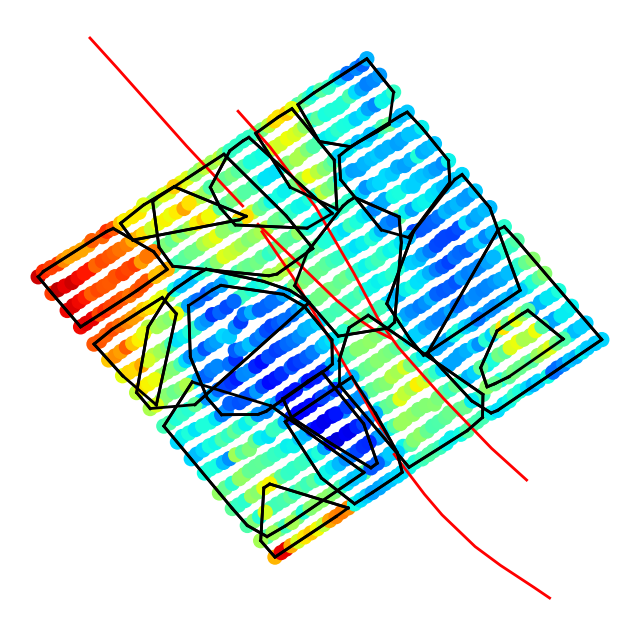

In [23]:
fig , ax00 = plt.subplots(1,1,figsize=(8,8))
for i in range(len(faults)):
    ax00.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'r',lw=2)
ax00.axis('off')
for cluster in range(n_clusters):
    cluster_points = np.column_stack((np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster]))
    hull = hull_all[cluster]
    hull_points = cluster_points[hull.vertices]
    ax00.plot(hull_points[:,0], hull_points[:,1], 'k-', lw=2)
    for simplex in hull.simplices:
        ax00.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', lw=2)
    im = ax00.scatter(np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster],c=np.array(c_mean_data)[clusters == cluster],cmap='jet',s=100,vmin = c_min,vmax = c_max)
    ax00.axis('off')
plt.savefig(dir_image + 'Autopick_Cluster_convex.png')

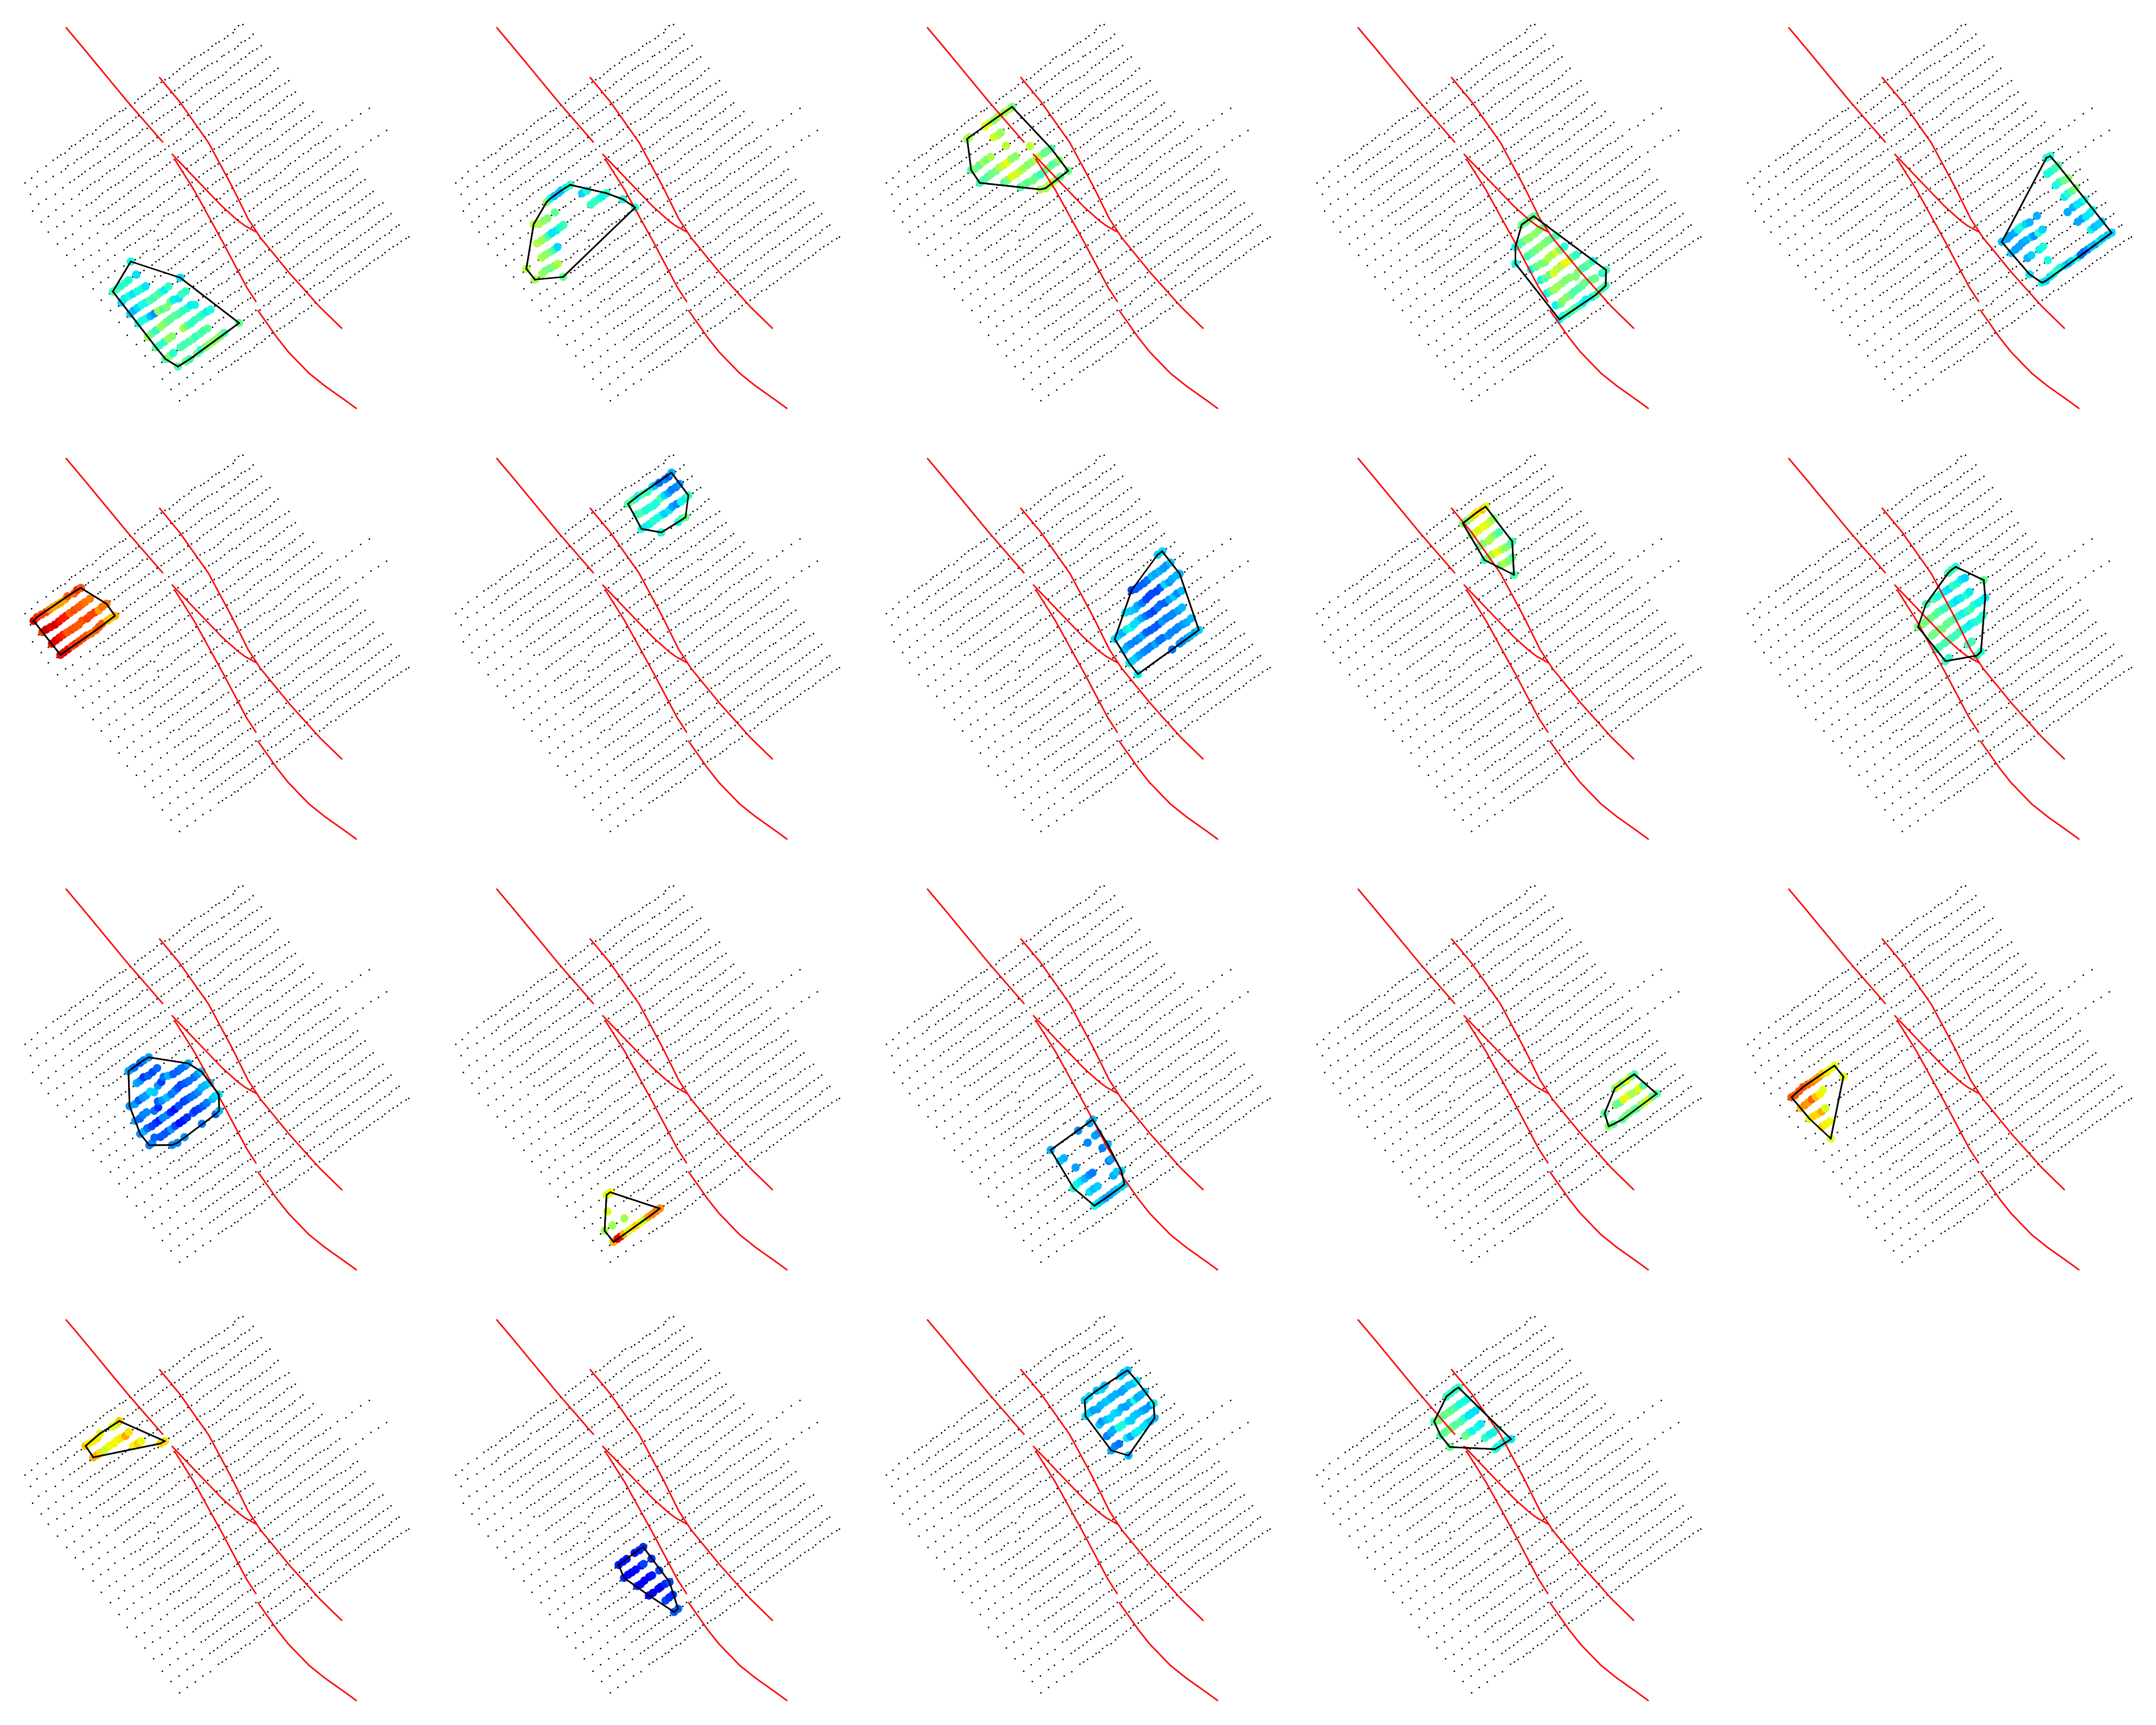

In [24]:
n_cols = int(np.ceil(np.sqrt(n_clusters)))
n_rows = int(np.ceil(n_clusters / n_cols))
fig = plt.figure(figsize=(8*(n_rows+1), 8*n_cols))

for cluster in range(n_clusters):
    col_num = cluster % n_cols
    row_num = int(cluster / n_cols)
    ax = plt.subplot(n_rows+1, n_cols, n_cols+cluster + 1)
    ax.scatter(lon_all, lat_all,marker='.',color='k',s=5)
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'r',lw=2)
    ax.axis('off')
    cluster_points = np.column_stack((np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster]))
    hull = hull_all[cluster]
    hull_points = cluster_points[hull.vertices]
    ax.plot(hull_points[:,0], hull_points[:,1], 'k-', lw=2)
    for simplex in hull.simplices:
        ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', lw=2)
    im = ax.scatter(np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster],c=np.array(c_mean_data)[clusters == cluster],cmap='jet',s=100,vmin = c_min,vmax = c_max)
    ax.axis('off')
plt.tight_layout()
plt.savefig(dir_image + 'Autopick_Cluster_convex_all.png')

### Repartrition based on envelop

In [25]:
def is_point_in_polygon(point, polygon):
    """
    判断点是否在多边形内部
    :param point: 点坐标
    :param polygon: 多边形坐标
    :return: True or False
    """
    x = point[0]
    y = point[1]
    poly = polygon
    poly = np.array(poly)
    if poly.shape[0] < 3:
        raise ValueError('polygon must be a vertex list of at least 3 tuples')
    n = poly.shape[0]
    inside = False
    p1x = poly[0][0]
    p1y = poly[0][1]
    for i in range(n + 1):
        p2x = poly[i % n][0]
        p2y = poly[i % n][1]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y)*(p2x - p1x)/(p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

In [26]:
Zones = {}
# 根据convex的边界，将所有在边界内的站点划分为一个区域，即一个Zone
for cluster in range(n_clusters):
    cluster_points = np.column_stack((np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster]))
    hull = hull_all[cluster]
    hull_points = cluster_points[hull.vertices]
    Zones[cluster] = []
    for i in range(len(lon_this)):
        if is_point_in_polygon([lon_this[i],lat_this[i]],hull_points):
            Zones[cluster].append(key_subworks_based[i])

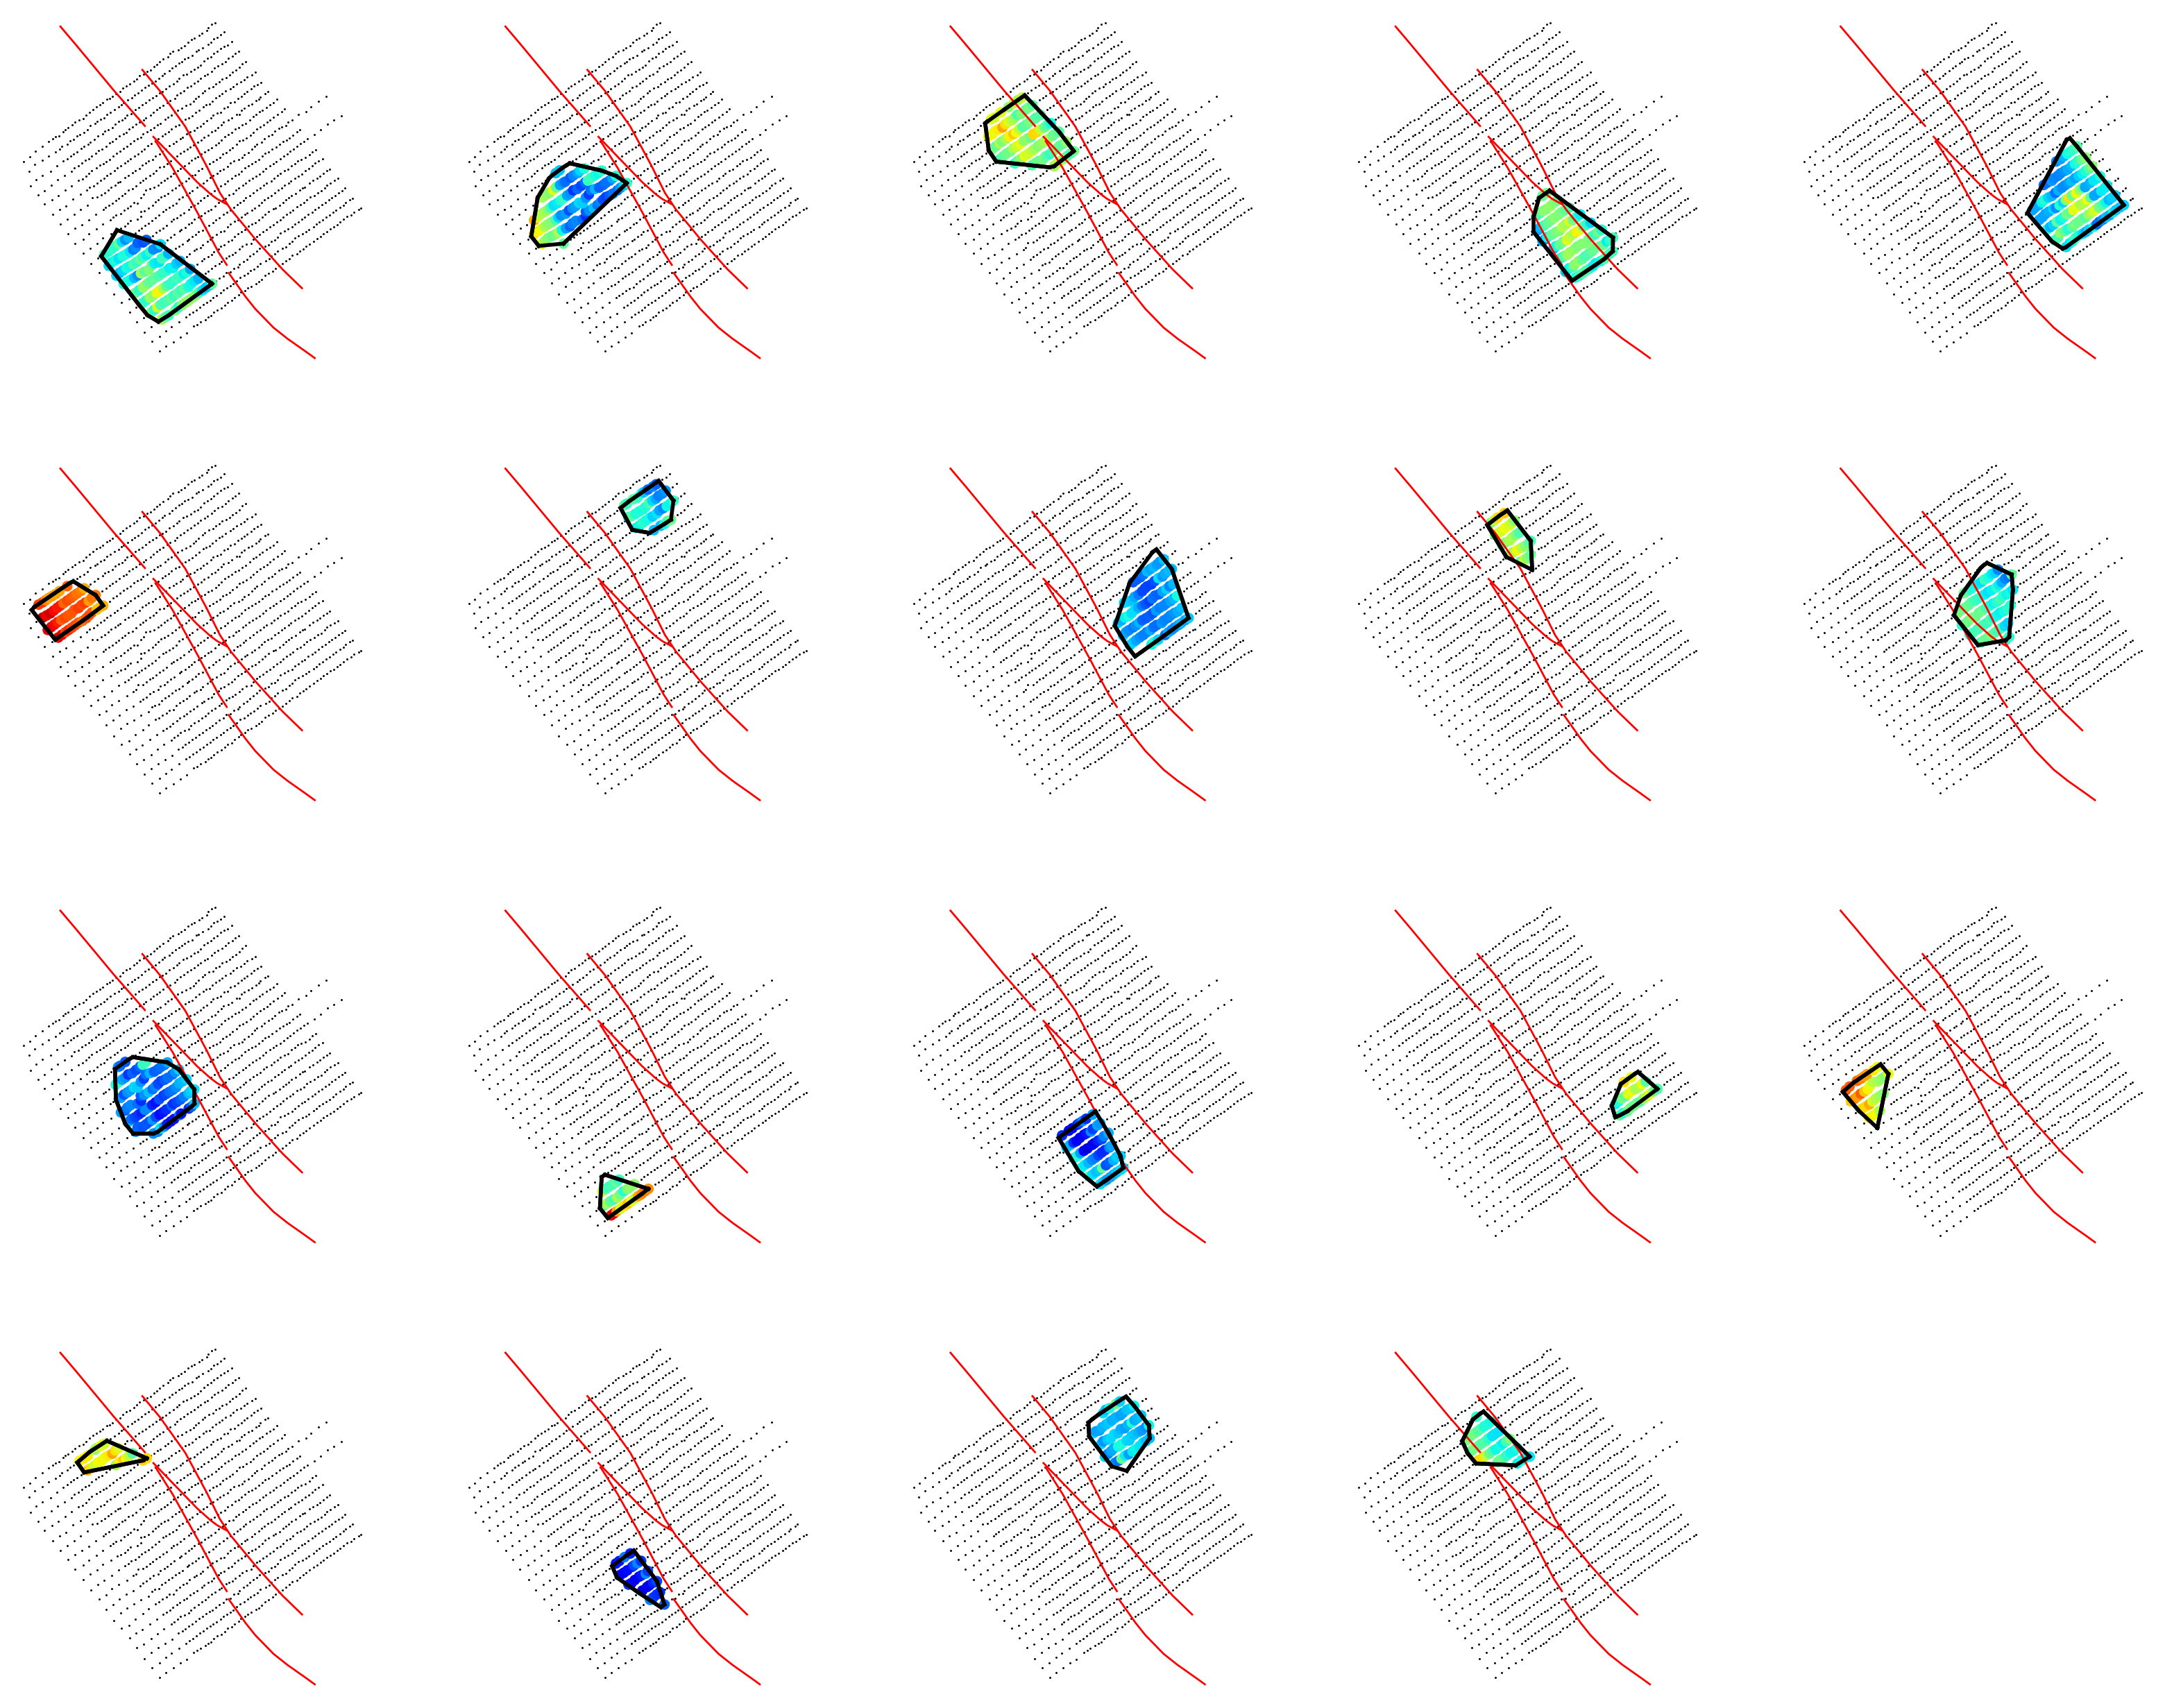

In [27]:
# 根据Zone，画出每个Zone的边界，以及每个Zone的站点对应的C值，每个Zone画一个图
n_cols = int(np.ceil(np.sqrt(n_clusters)))
n_rows = int(np.ceil(n_clusters / n_cols))
fig = plt.figure(figsize=(8*(n_rows+1), 8*n_cols))
for cluster in range(n_clusters):
    cluster_points = np.column_stack((np.array(lon_this)[clusters == cluster], np.array(lat_this)[clusters == cluster]))
    hull = hull_all[cluster]
    hull_points = cluster_points[hull.vertices]
    zone = Zones[cluster]
    col_num = cluster % n_cols
    row_num = int(cluster / n_cols)
    ax = plt.subplot(n_rows+1, n_cols, n_cols+cluster + 1)
    ax.scatter(lon_all, lat_all,marker='.',color='k',s=5)
    for i in range(len(faults)):
        ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'r', lw=2)
    
    zone_points = np.zeros((len(zone),3))
    for i in range(len(zone)):
        key_subwork = zone[i]
        zone_points[i] = [lon_this[key_subworks_based.index(key_subwork)],lat_this[key_subworks_based.index(key_subwork)],c_mean_data[key_subworks_based.index(key_subwork)]]
    im = ax.scatter(np.array(zone_points[:,0]), np.array(zone_points[:,1]),c=np.array(zone_points[:,2]),cmap='jet',s=100,vmin = c_min,vmax = c_max)
    
    ax.plot(hull_points[:,0], hull_points[:,1], 'k-', lw=4)
    for simplex in hull.simplices:
        ax.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', lw=4)
    
    ax.axis('off')
plt.savefig(dir_image + 'Repartrition.png')

### Storage for different partrition

In [28]:
stalistname_based = info_basic_based['stalistname']
sta_all = pd.read_excel(dir_project_based + stalistname_based,sheet_name = None,engine='openpyxl') 

In [29]:
filename = 'stations_info.xlsx'
if os.path.exists(dir_project+filename):
    os.remove(dir_project+filename)
# 创建filename的excel文件

In [30]:
for key in Zones.keys():
    zone = Zones[key]
    stalist_zone = set()
    for key_subwork in zone:
        stainfo = sta_all[key_subwork]
        stalist = set(stainfo['Station'].tolist())
        stalist_zone = stalist_zone.union(stalist)
    stalist_zone = list(stalist_zone)
    df = pd.DataFrame()
    df['Station'] = stalist_zone
    df['latitude'] = [lat_all[stalist_all.index(key_this)] for key_this in stalist_zone]
    df['longitude'] = [lon_all[stalist_all.index(key_this)] for key_this in stalist_zone]
    #df['c_mean'] = [c_mean[key_this[1:3]+'-'+key_this[3:]] for key_this in stalist_zone]
    #df.to_excel(dir_project+filename,sheet_name=str(key),index=False)
    # 将df写入到filename的excel文件中
    if not os.path.exists(dir_project+filename):
        df.to_excel(dir_project+filename, sheet_name=str(key),index=False)
        books = load_workbook(dir_project+filename)
        writers = pd.ExcelWriter(dir_project+filename, engine='openpyxl')
        writers.book = books
    else:
        df.to_excel(writers,str(key),index=False)
    print('finish '+str(key)+'\n')
info_basic['stalistname'] = filename
info_basic['stalistname_all'] = info_basic_based['stalistname_all']
writers.save()

finish 0

finish 1

finish 2

finish 3

finish 4

finish 5

finish 6

finish 7

finish 8

finish 9

finish 10

finish 11

finish 12

finish 13

finish 14

finish 15

finish 16

finish 17

finish 18



In [31]:
info_basic_bi['c_mean'] = c_mean
info_basic['key_subworks'] = [str(key) for key in Zones.keys()]
for key in Zones.keys():
    info_basic['key_this_'+str(key)] = Zones[key]

In [32]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)
np.save(dir_project + '/Basic_info.npy', info_basic_bi)